# Projeto de Aplicação - Malicious Traffic Detection in IoT
Healthcare Environment
- Programa de Pós-Graduação em Computação
- Aprendizado de Máquina na Saúde
- Prof. Flávio Luiz Seixas

- Nome: Augusto Cesar da F. dos Santos
- Matrícula: M048.124.004



frame.time_relative: O tempo relativo desde o início da captura, útil para analisar intervalos de pacotes.

tcp.time_delta: Diferença de tempo entre pacotes TCP, indicando atrasos na transmissão.

tcp.flags.push: Mostra se a flag de push do TCP está ativada, indicando transferência imediata de dados.

tcp.hdr_len: Comprimento do cabeçalho TCP, relevante para identificar a estrutura do pacote.

tcp.pdu.size: Tamanho da Unidade de Dados de Protocolo (PDU) em TCP, medindo o tamanho da carga útil.

tcp.window_size_value: Tamanho da janela TCP, impacta o controle de fluxo.

mqtt.hdrflags: Flags de cabeçalho em pacotes MQTT, úteis para o controle do protocolo.

mqtt.kalive: Tempo de keep-alive do MQTT, que ajuda na gestão de sessões.

mqtt.len: Comprimento do payload da mensagem MQTT.

mqtt.msgtype: Tipo de mensagem MQTT (e.g., CONNECT, PUBLISH).

mqtt.topic_len: Comprimento do tópico MQTT, relacionado ao destino da mensagem.

mqtt.ver: Versão do MQTT utilizada.

ip.ttl: valor de Time-to-Live (TTL) do IP, afetando a vida útil do pacote.

tcp.flags.ack: Status da flag de reconhecimento TCP.

tcp.flags.syn: Flag de sincronização TCP, inicia uma conexão.

rótulo: Indica se o tráfego é malicioso ou benigno.

Um ataque de MQTT Distributed Denial of Service (DDoS) exploraria principalmente os seguintes atributos:

mqtt.hdrflags: Sinais específicos no cabeçalho podem ajudar a identificar ataques, como tentativas de sobrecarregar o sistema.
mqtt.kalive: Um valor de keep-alive inadequado pode ser manipulado para manter conexões ativas por longos períodos, sobrecarregando o servidor.
mqtt.len: Tamanhos de mensagem anormais podem indicar tráfego excessivo.
mqtt.msgtype: Tipos específicos de mensagens, como PUBLISH, podem ser usados repetidamente para saturar o sistema.

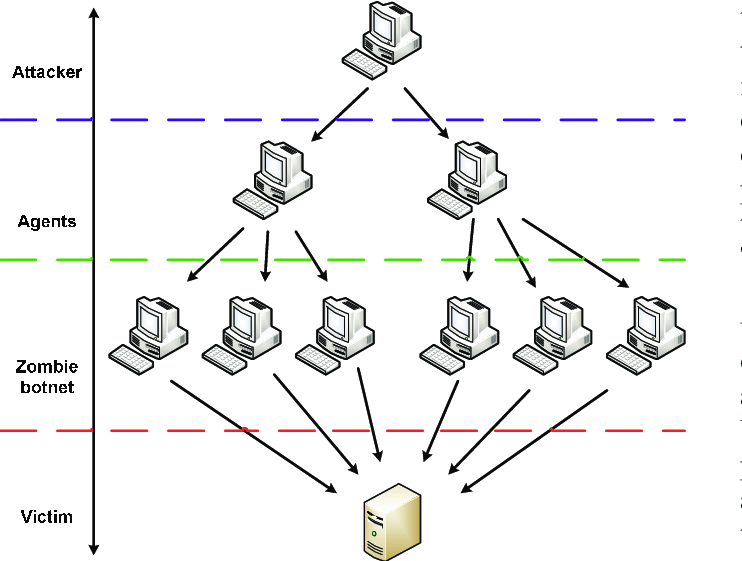

In [74]:
import pandas as pd
import numpy as np

import missingno as missno
import io, os

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
#plt.figure(figsize=(largura, altura))
plt.rcParams["figure.figsize"] = (8, 6)

from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, f_classif

from pprint import pprint
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split, cross_val_predict, KFold,cross_val_score

from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,ConfusionMatrixDisplay, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

from google.colab import drive


In [3]:
#Montando o drive para carregar o arquivo
GOOGLE_COLAB = "google.colab" in str(get_ipython())

if GOOGLE_COLAB:
    from google.colab import drive
    drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [4]:
drive = '/content/drive/MyDrive/2024-2/4 - AM_na_saude/projeto_app/ICUDatasetProcessed/'

In [5]:
csvs = os.listdir(drive)
csvs

['Attack.csv', 'patientMonitoring.csv', 'environmentMonitoring.csv']

In [6]:
total_rows=0
for csv in csvs:
    data = pd.read_csv(drive + csv)
    total_rows+=len(data)
    print(f'O arquivo {csv} tem {data.shape[0]} linhas e {data.shape[1]} colunas.')
    print(f'Total esperado de linhas: {total_rows}')

O arquivo Attack.csv tem 80126 linhas e 52 colunas.
Total esperado de linhas: 80126
O arquivo patientMonitoring.csv tem 76810 linhas e 52 colunas.
Total esperado de linhas: 156936
O arquivo environmentMonitoring.csv tem 31758 linhas e 52 colunas.
Total esperado de linhas: 188694


In [7]:
df1 = pd.read_csv(os.path.join(drive, 'environmentMonitoring.csv'))
df2 = pd.read_csv(os.path.join(drive, 'Attack.csv'))
df3 = pd.read_csv(os.path.join(drive, 'patientMonitoring.csv'))

In [8]:
# Extrair nomes das colunas de cada DataFrame
colunas_df1 = set(df1.columns)
colunas_df2 = set(df2.columns)
colunas_df3 = set(df3.columns)

# Verificar se os nomes das colunas são os mesmos
if colunas_df1 == colunas_df2 == colunas_df3:
    print("Todos os arquivos têm os mesmos nomes de colunas.")
else:
    print("Os arquivos têm nomes de colunas diferentes.")

    # Mostrar diferenças
    print("Colunas em arquivo1 e não em arquivo2:", colunas_df1 - colunas_df2)
    print("Colunas em arquivo2 e não em arquivo3:", colunas_df2 - colunas_df3)
    print("Colunas em arquivo3 e não em arquivo1:", colunas_df3 - colunas_df1)

Todos os arquivos têm os mesmos nomes de colunas.


In [ ]:
df1.info()

In [ ]:
df1.sample(5)

In [ ]:
df1.describe().T

In [ ]:
df2.info()

In [ ]:
df2.sample(5)

In [ ]:
df2.describe().T

In [ ]:
df3.info()

In [ ]:
df3.sample(5)

In [ ]:
df3.describe().T

In [9]:
df = pd.concat([df1, df2, df3], ignore_index=True)
df.shape

(188694, 52)

In [10]:
print(df.duplicated().sum())

2


In [11]:
df = df.drop_duplicates()

In [12]:
print(df.duplicated().sum())

0


In [13]:
# Lista para armazenar nomes das colunas que estão completamente vazias
empty_cols=[]

# Itera sobre cada coluna do dataframe
for col in df.columns:
  if df[col].isnull().all():
    empty_cols.append(col)
    if len(empty_cols == []):
      df.fillna(0, inplace=True)

print(f'Colunas vazias: {empty_cols}')

Colunas vazias: []


In [14]:
nan_count = df.isna().any(axis=1).sum()
print(f"Número de linhas com pelo menos um NaN: {nan_count}")

Número de linhas com pelo menos um NaN: 0


In [15]:
# Contar o número de NaN por coluna
nan_count_per_column = df.isna().sum()
print("Número de NaN por coluna:")
print(nan_count_per_column)

Número de NaN por coluna:
frame.time_delta         0
frame.time_relative      0
frame.len                0
ip.src                   0
ip.dst                   0
tcp.srcport              0
tcp.dstport              0
tcp.flags                0
tcp.time_delta           0
tcp.len                  0
tcp.ack                  0
tcp.connection.fin       0
tcp.connection.rst       0
tcp.connection.sack      0
tcp.connection.syn       0
tcp.flags.ack            0
tcp.flags.fin            0
tcp.flags.push           0
tcp.flags.reset          0
tcp.flags.syn            0
tcp.flags.urg            0
tcp.hdr_len              0
tcp.payload              0
tcp.pdu.size             0
tcp.window_size_value    0
tcp.checksum             0
mqtt.clientid            0
mqtt.clientid_len        0
mqtt.conack.flags        0
mqtt.conack.val          0
mqtt.conflag.passwd      0
mqtt.conflag.qos         0
mqtt.conflag.reserved    0
mqtt.conflag.retain      0
mqtt.conflag.willflag    0
mqtt.conflags            0
mq

In [16]:
df = df.dropna(axis=0, how='any')

In [17]:
df = df.loc[:, df.nunique() > 1]

In [18]:
df.columns

Index(['frame.time_delta', 'frame.time_relative', 'frame.len', 'ip.src',
       'ip.dst', 'tcp.srcport', 'tcp.dstport', 'tcp.flags', 'tcp.time_delta',
       'tcp.len', 'tcp.ack', 'tcp.connection.fin', 'tcp.connection.rst',
       'tcp.connection.sack', 'tcp.connection.syn', 'tcp.flags.ack',
       'tcp.flags.fin', 'tcp.flags.push', 'tcp.flags.reset', 'tcp.flags.syn',
       'tcp.hdr_len', 'tcp.payload', 'tcp.pdu.size', 'tcp.window_size_value',
       'tcp.checksum', 'mqtt.clientid', 'mqtt.clientid_len',
       'mqtt.conack.flags', 'mqtt.conflags', 'mqtt.dupflag', 'mqtt.hdrflags',
       'mqtt.kalive', 'mqtt.len', 'mqtt.msg', 'mqtt.msgtype', 'mqtt.qos',
       'mqtt.retain', 'mqtt.topic', 'mqtt.topic_len', 'mqtt.ver', 'ip.ttl',
       'class', 'label'],
      dtype='object')

In [19]:
len(df.columns)

43

In [22]:
def unique_vals(df, columns):
  for col_name in columns:
    print(f"Colunas: {col_name}\n{'-'*30}")
    unique_vals = df[col_name].unique()
    len_unique_vals = len(unique_vals)
    value_counts = df[col_name].value_counts()

    print(f'Valores Unicos: {len_unique_vals}\n')
    print(f"Value Counts: {value_counts}\n{'='*40}\n")

columns = df.columns.to_list()
unique_vals(df, columns)

Colunas: frame.time_delta
------------------------------
Valores Unicos: 11904

Value Counts: frame.time_delta
0.000001    14271
0.000000    12088
0.000003     2735
0.000025     2599
0.000024     2567
            ...  
6.886630        1
0.052399        1
0.051140        1
0.043011        1
0.004245        1
Name: count, Length: 11904, dtype: int64

Colunas: frame.time_relative
------------------------------
Valores Unicos: 176587

Value Counts: frame.time_relative
0.000000       8
36.572407      6
31.547406      6
40.406267      6
11.132515      6
              ..
21.247532      1
21.247564      1
21.265037      1
21.265987      1
6611.038212    1
Name: count, Length: 176587, dtype: int64

Colunas: frame.len
------------------------------
Valores Unicos: 633

Value Counts: frame.len
80      24622
54      18851
78      18603
86      17470
77      16885
        ...  
1226        1
1234        1
1108        1
1407        1
1120        1
Name: count, Length: 633, dtype: int64

Colunas: ip.

In [23]:
categ_feat = df.select_dtypes(include=['object']).columns
unique_vals(df, categ_feat)

Colunas: ip.src
------------------------------
Valores Unicos: 44

Value Counts: ip.src
192.168.1.90    46208
192.168.1.91    24714
10.5.126.147    10596
10.5.126.145    10596
10.5.126.148    10518
10.5.126.146    10518
10.5.126.167     6858
10.5.126.165     6858
10.5.126.168     6782
10.5.126.166     6780
10.5.126.84      6084
10.16.120.44     5114
10.5.126.56      4544
10.16.120.72     4088
10.5.150.109     3222
10.5.150.157     1436
10.5.150.152     1436
10.5.150.156     1436
10.5.126.136     1356
10.5.126.137     1356
10.5.126.157     1356
10.5.126.132     1356
10.5.126.156     1356
10.5.126.152     1356
10.5.126.151      840
10.5.126.153      840
10.5.126.155      840
10.5.126.135      840
10.5.126.131      840
10.5.126.154      840
10.5.126.133      840
10.5.126.134      840
10.5.150.155      822
10.5.150.153      822
10.5.150.154      822
10.5.150.151      822
10.5.126.144      416
10.5.126.143      416
10.5.126.141      416
10.5.126.142      416
10.5.126.161      274
10.5.126.1

In [24]:
list_feat=[]
for feats in categ_feat:
  list_feat.append(feats)
  len_feat = len(list_feat)

print(f'Atributos categóricos: {list_feat}\n')
print(f'Tamanho: {len_feat}')

Atributos categóricos: ['ip.src', 'ip.dst', 'tcp.flags', 'tcp.payload', 'tcp.checksum', 'mqtt.clientid', 'mqtt.conack.flags', 'mqtt.conflags', 'mqtt.hdrflags', 'mqtt.msg', 'mqtt.topic', 'class']

Tamanho: 12


In [25]:
numeric_feats = df.select_dtypes(include=['float64', 'int64']).columns
unique_vals(df, numeric_feats)

Colunas: frame.time_delta
------------------------------
Valores Unicos: 11904

Value Counts: frame.time_delta
0.000001    14271
0.000000    12088
0.000003     2735
0.000025     2599
0.000024     2567
            ...  
6.886630        1
0.052399        1
0.051140        1
0.043011        1
0.004245        1
Name: count, Length: 11904, dtype: int64

Colunas: frame.time_relative
------------------------------
Valores Unicos: 176587

Value Counts: frame.time_relative
0.000000       8
36.572407      6
31.547406      6
40.406267      6
11.132515      6
              ..
21.247532      1
21.247564      1
21.265037      1
21.265987      1
6611.038212    1
Name: count, Length: 176587, dtype: int64

Colunas: frame.len
------------------------------
Valores Unicos: 633

Value Counts: frame.len
80      24622
54      18851
78      18603
86      17470
77      16885
        ...  
1226        1
1234        1
1108        1
1407        1
1120        1
Name: count, Length: 633, dtype: int64

Colunas: tcp

In [26]:
list_feat_num=[]
for feats in numeric_feats:
  list_feat_num.append(feats)
  len_feat_num = len(list_feat_num)

print(f'Atributos numéricos: {list_feat_num}\n')
print(f'Tamanho: {len_feat_num}')

Atributos numéricos: ['frame.time_delta', 'frame.time_relative', 'frame.len', 'tcp.srcport', 'tcp.dstport', 'tcp.time_delta', 'tcp.len', 'tcp.ack', 'tcp.connection.fin', 'tcp.connection.rst', 'tcp.connection.sack', 'tcp.connection.syn', 'tcp.flags.ack', 'tcp.flags.fin', 'tcp.flags.push', 'tcp.flags.reset', 'tcp.flags.syn', 'tcp.hdr_len', 'tcp.pdu.size', 'tcp.window_size_value', 'mqtt.clientid_len', 'mqtt.dupflag', 'mqtt.kalive', 'mqtt.len', 'mqtt.msgtype', 'mqtt.qos', 'mqtt.retain', 'mqtt.topic_len', 'mqtt.ver', 'ip.ttl', 'label']

Tamanho: 31


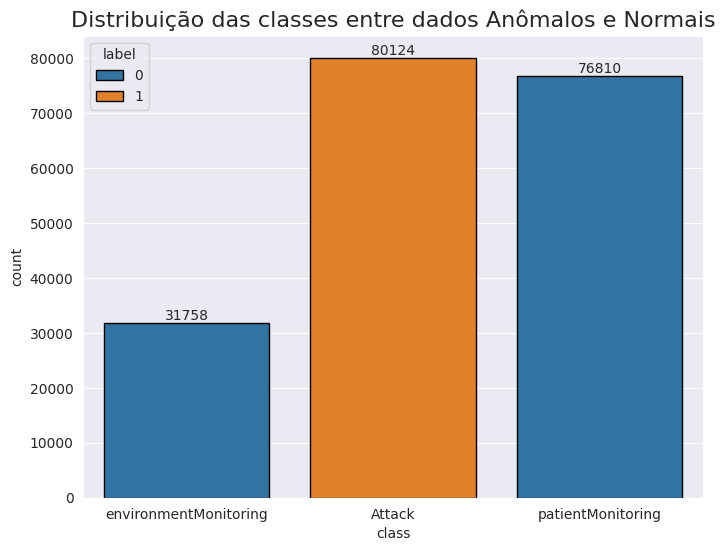

In [27]:
sns.set_style("darkgrid")
ax = sns.countplot(
    data=df,
    x='class',
    hue='label',
    edgecolor='black')

ax.set_title('Distribuição das classes entre dados Anômalos e Normais',
         fontdict={'fontsize':16})

for container in ax.containers:
  ax.bar_label(container)

In [20]:
df_label_count = df.groupby('label').size().reset_index(name='count')
df_label_count.columns = ['label', 'count']

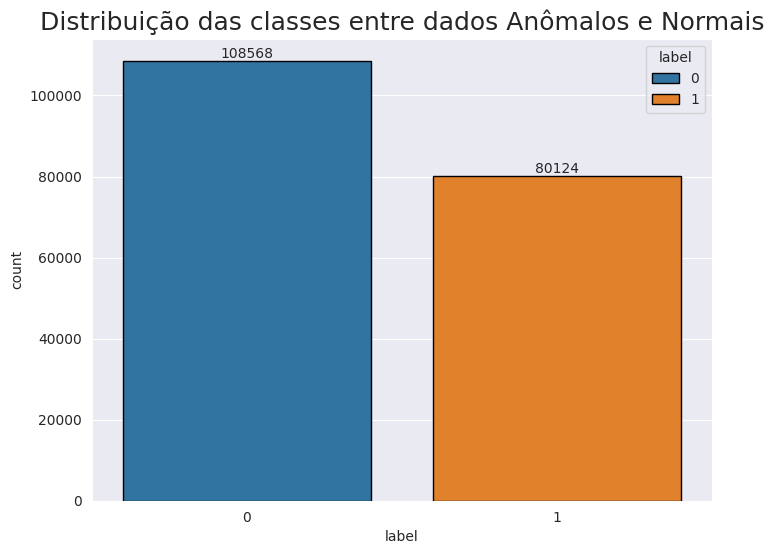

In [28]:
ax = sns.barplot(
    data = df_label_count,
    x= 'label',
    y= 'count',
    hue= 'label',
    edgecolor='black')

ax.set_title('Distribuição das classes entre dados Anômalos e Normais',
          fontdict={'fontsize':18})

for container in ax.containers:
   ax.bar_label(container)

In [21]:
count_val0 = df_label_count[df_label_count['label'] == 0]['count'].iloc[0]
count_val1 = df_label_count[df_label_count['label'] == 1]['count'].iloc[0]

print(f'Proporção de Classes:\n')
print(f'Instâncias normais: {count_val0/len(df)*100:.2f}%')
print(f'Instâncias anômalas: {count_val1/len(df)*100:.2f}%')

Proporção de Classes:

Instâncias normais: 57.54%
Instâncias anômalas: 42.46%


Indicação de Controle de Fluxo:

O uso da feature mqtt.hdrflags é comum porque essa informação específica pode ser crucial para detectar comportamentos anômalos e atividades maliciosas no tráfego IoT, especialmente no contexto de protocolos como o MQTT

O campo mqtt.hdrflags contém bits de controle importantes, como o tipo de mensagem e configurações de QoS (Quality of Service). Em um ambiente seguro e legítimo, espera-se que certos padrões sejam seguidos nesses campos de controle.
Qualquer discrepância ou configuração incomum nos bits de controle pode indicar uma tentativa de ataque, como spoofing ou negação de serviço.
Detecção de Ataques de Integração e Autenticidade:

Em um ambiente de saúde IoT, ataques de replay ou spoofing podem comprometer a integridade dos dados dos dispositivos médicos.
Alterações ou padrões incomuns nos bits de mqtt.hdrflags podem ser indicadores de que as mensagens foram modificadas ou não são autênticas, o que é um sinal de intrusão.
Identificação de Padrões de QoS:

MQTT usa diferentes níveis de QoS para garantir a entrega de mensagens. Em sistemas de IoT para saúde, um nível específico de QoS é normalmente adotado para certos dispositivos ou aplicações.
Se mqtt.hdrflags indicar níveis de QoS diferentes dos esperados, pode ser um sinal de que algo está fora do normal, potencialmente indicando um comportamento malicioso.
Simplicidade e Frequência do Tráfego MQTT:

Em ambientes IoT, o tráfego MQTT é mais frequente do que o HTTP ou HTTPS, tornando o monitoramento de mqtt.hdrflags eficiente para capturar eventos relevantes em tempo real.
Como mqtt.hdrflags é uma das primeiras informações nos pacotes MQTT, ele oferece uma pista inicial rápida para detectar possíveis ameaças antes de uma análise mais detalhada.

In [41]:
label_encoder = preprocessing.LabelEncoder()
df['mqtt.hdrflags']= label_encoder.fit_transform(df['mqtt.hdrflags'])

In [42]:
category = ['ip.src', 'tcp.srcport', 'tcp.dstport', 'ip.dst', 'tcp.flags', 'tcp.payload', 'tcp.checksum',
            'mqtt.clientid', 'mqtt.conack.flags', 'mqtt.conflags', 'mqtt.msg', 'mqtt.topic', 'class']

In [43]:
df.drop(labels = category, axis=1, inplace=True)

KeyError: "['ip.src', 'tcp.srcport', 'tcp.dstport', 'ip.dst', 'tcp.flags', 'tcp.payload', 'tcp.checksum', 'mqtt.clientid', 'mqtt.conack.flags', 'mqtt.conflags', 'mqtt.msg', 'mqtt.topic', 'class'] not found in axis"

In [44]:
len(df.columns)

16

In [45]:
print(df.dtypes)

frame.time_relative      float64
tcp.time_delta           float64
tcp.flags.push             int64
tcp.hdr_len                int64
tcp.pdu.size             float64
tcp.window_size_value      int64
mqtt.hdrflags              int64
mqtt.kalive              float64
mqtt.len                 float64
mqtt.msgtype             float64
mqtt.topic_len           float64
mqtt.ver                 float64
ip.ttl                     int64
tcp.flags.ack              int64
tcp.flags.syn              int64
label                      int64
dtype: object


In [ ]:
df_corr = df

In [ ]:
corr_matrix = df_corr.corr()

In [ ]:
# corr_matrix

,frame.time_delta,frame.time_relative,frame.len,tcp.time_delta,tcp.len,tcp.ack,tcp.connection.fin,tcp.connection.rst,tcp.connection.sack,tcp.connection.syn,...,mqtt.hdrflags,mqtt.kalive,mqtt.len,mqtt.msgtype,mqtt.qos,mqtt.retain,mqtt.topic_len,mqtt.ver,ip.ttl,label
frame.time_delta,1.000000,0.084561,-0.050260,0.038235,-0.052725,-0.056634,-0.018219,-0.017944,-0.019690,0.007793,...,-0.031341,-0.014283,-0.064337,-0.003120,-0.003258,-0.004804,-0.066396,-0.019741,-0.070654,-0.155114
frame.time_relative,0.084561,1.000000,-0.193739,0.176959,-0.203208,-0.214635,-0.062699,-0.062223,-0.073101,-0.073101,...,0.049803,-0.055995,-0.252745,0.247235,-0.281589,-0.016964,-0.218143,-0.074170,-0.283767,-0.632077
frame.len,-0.050260,-0.193739,1.000000,-0.076980,0.999825,-0.062829,-0.028981,-0.031460,-0.029304,-0.027549,...,0.128448,-0.021454,0.690050,-0.015736,0.592900,0.036201,0.690068,-0.024804,-0.102461,0.303510
tcp.time_delta,0.038235,0.176959,-0.076980,1.000000,-0.080647,-0.084730,-0.027084,-0.026945,-0.029396,-0.029414,...,0.239444,-0.021243,-0.108177,0.362708,-0.080778,-0.007272,-0.102146,-0.029654,-0.111458,-0.245813
tcp.len,-0.052725,-0.203208,0.999825,-0.080647,1.000000,-0.055255,-0.027055,-0.028669,-0.031281,-0.031281,...,0.127630,-0.021941,0.694663,-0.020438,0.596359,0.036607,0.694012,-0.023989,-0.093214,0.318520
tcp.ack,-0.056634,-0.214635,-0.062829,-0.084730,-0.055255,1.000000,-0.027191,-0.027531,-0.030039,-0.030040,...,0.251215,-0.021699,-0.113787,0.051405,-0.113055,-0.007429,-0.137532,-0.030289,0.713544,0.338443
tcp.connection.fin,-0.018219,-0.062699,-0.028981,-0.027084,-0.027055,-0.027191,1.000000,-0.008778,-0.009578,-0.009578,...,-0.085150,-0.006919,-0.037894,-0.065103,-0.042936,-0.002370,-0.039761,-0.009658,0.102007,0.109364
tcp.connection.rst,-0.017944,-0.062223,-0.031460,-0.026945,-0.028669,-0.027531,-0.008778,1.000000,-0.009525,-0.009525,...,-0.128270,-0.006881,-0.046656,-0.111240,-0.042699,-0.002357,-0.051403,-0.009604,-0.036273,0.108761
tcp.connection.sack,-0.019690,-0.073101,-0.029304,-0.029396,-0.031281,-0.030039,-0.009578,-0.009525,1.000000,-0.010394,...,-0.139960,-0.007508,-0.050908,-0.121377,-0.046591,-0.002572,-0.056087,-0.010480,0.103184,0.118673
tcp.connection.syn,0.007793,-0.073101,-0.027549,-0.029414,-0.031281,-0.030040,-0.009578,-0.009525,-0.010394,1.000000,...,-0.139960,-0.007508,-0.050908,-0.121377,-0.046591,-0.002572,-0.056087,-0.010480,-0.039579,0.118673


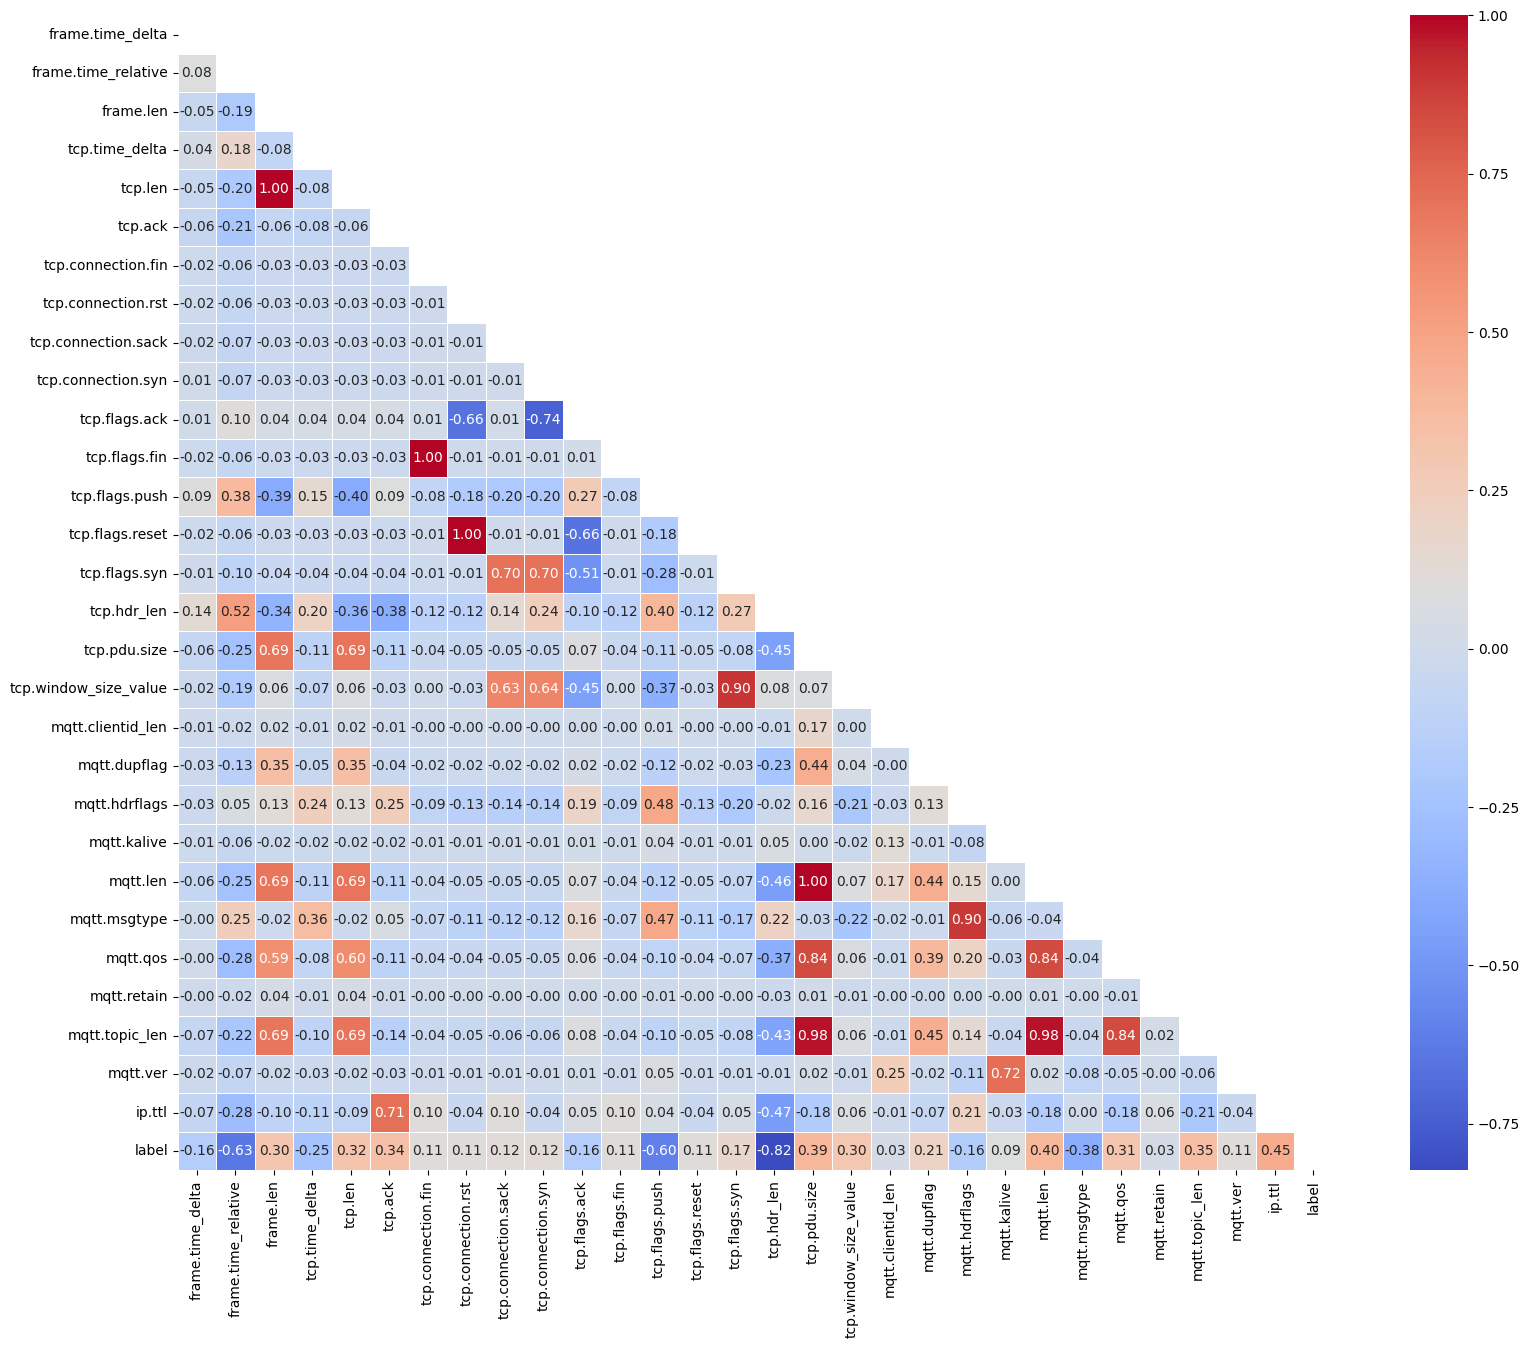

In [ ]:
plt.figure(figsize=(20, 15))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix,
            annot=True,
            mask=mask,
            linewidth=.5,
            fmt="0.2f",
            cmap='coolwarm',
            square=True)
plt.show()

In [ ]:
# Filtrar as correlações que sejam maiores que 0.5 ou menores que -0.5
high_correlation = corr_matrix[~((corr_matrix > 0.5) | (corr_matrix < -0.5))]

In [ ]:
high_correlation.value_counts()

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,count
frame.time_delta,frame.time_relative,frame.len,tcp.time_delta,tcp.len,tcp.ack,tcp.connection.fin,tcp.connection.rst,tcp.connection.sack,tcp.connection.syn,tcp.flags.ack,tcp.flags.fin,tcp.flags.push,tcp.flags.reset,tcp.flags.syn,tcp.hdr_len,tcp.pdu.size,tcp.window_size_value,mqtt.clientid_len,mqtt.dupflag,mqtt.hdrflags,mqtt.kalive,mqtt.len,mqtt.msgtype,mqtt.qos,mqtt.retain,mqtt.topic_len,mqtt.ver,ip.ttl,label,


In [ ]:
# # Ordenar as variáveis em cada par para evitar duplicatas invertidas
# high_correlation['Pair'] = high_correlation.apply(lambda row: tuple(sorted([row['Variable_1'], row['Variable_2']])), axis=1)
# # Remover duplicatas com base nos pares únicos
# unique_high_correlation = high_correlation.drop_duplicates(subset='Pair').drop(columns='Pair')
# print(unique_high_correlation)

KeyError: 'Variable_1'

In [ ]:
# # Suponha que high_correlation seja o DataFrame com pares de correlação já filtrados
# # Ordenar pelos valores absolutos da correlação em ordem decrescente
# high_correlation['Abs_Correlation'] = high_correlation['Correlation'].abs()
# high_correlation = high_correlation.sort_values(by='Abs_Correlation', ascending=False)

# # Conjunto para armazenar as variáveis que já foram selecionadas
# selected_variables = set()
# unique_pairs = []

# # Iterar pelos pares de correlação
# for _, row in high_correlation.iterrows():
#     var1, var2 = row['Variable_1'], row['Variable_2']
#     # Se nenhuma das variáveis já foi selecionada, adicioná-las ao conjunto
#     if var1 not in selected_variables and var2 not in selected_variables:
#         unique_pairs.append(row)
#         selected_variables.update([var1, var2])  # Marcar variáveis como selecionadas

# # Converter o resultado final para um DataFrame
# unique_high_correlation = pd.DataFrame(unique_pairs).drop(columns='Abs_Correlation')

# print(unique_high_correlation)

KeyError: 'Correlation'

In [ ]:
unique_high_correlation

,Variable_1,Variable_2,Correlation,Pair
341,tcp.flags.push,mqtt.hdrflags,0.477927,"(mqtt.hdrflags, tcp.flags.push)"
764,ip.ttl,tcp.hdr_len,-0.472241,"(ip.ttl, tcp.hdr_len)"
461,tcp.window_size_value,tcp.flags.ack,-0.452645,"(tcp.flags.ack, tcp.window_size_value)"
714,mqtt.topic_len,mqtt.dupflag,0.447982,"(mqtt.dupflag, mqtt.topic_len)"
797,label,mqtt.len,0.397366,"(label, mqtt.len)"
620,mqtt.msgtype,tcp.time_delta,0.362708,"(mqtt.msgtype, tcp.time_delta)"
51,frame.time_relative,mqtt.qos,-0.281589,"(frame.time_relative, mqtt.qos)"
740,mqtt.ver,mqtt.clientid_len,0.254332,"(mqtt.clientid_len, mqtt.ver)"
148,tcp.ack,tcp.pdu.size,-0.112453,"(tcp.ack, tcp.pdu.size)"
3,frame.time_delta,tcp.len,-0.052725,"(frame.time_delta, tcp.len)"


In [46]:
best_features = ['frame.time_relative', 'tcp.time_delta', 'tcp.flags.push', 'tcp.hdr_len', 'tcp.pdu.size', 'tcp.window_size_value', 'mqtt.hdrflags',
                 'mqtt.kalive', 'mqtt.len', 'mqtt.msgtype', 'mqtt.topic_len', 'mqtt.ver', 'ip.ttl','tcp.flags.ack', 'tcp.flags.syn', 'label']

In [47]:
df = df[best_features]

<Figure size 1200x1000 with 0 Axes>

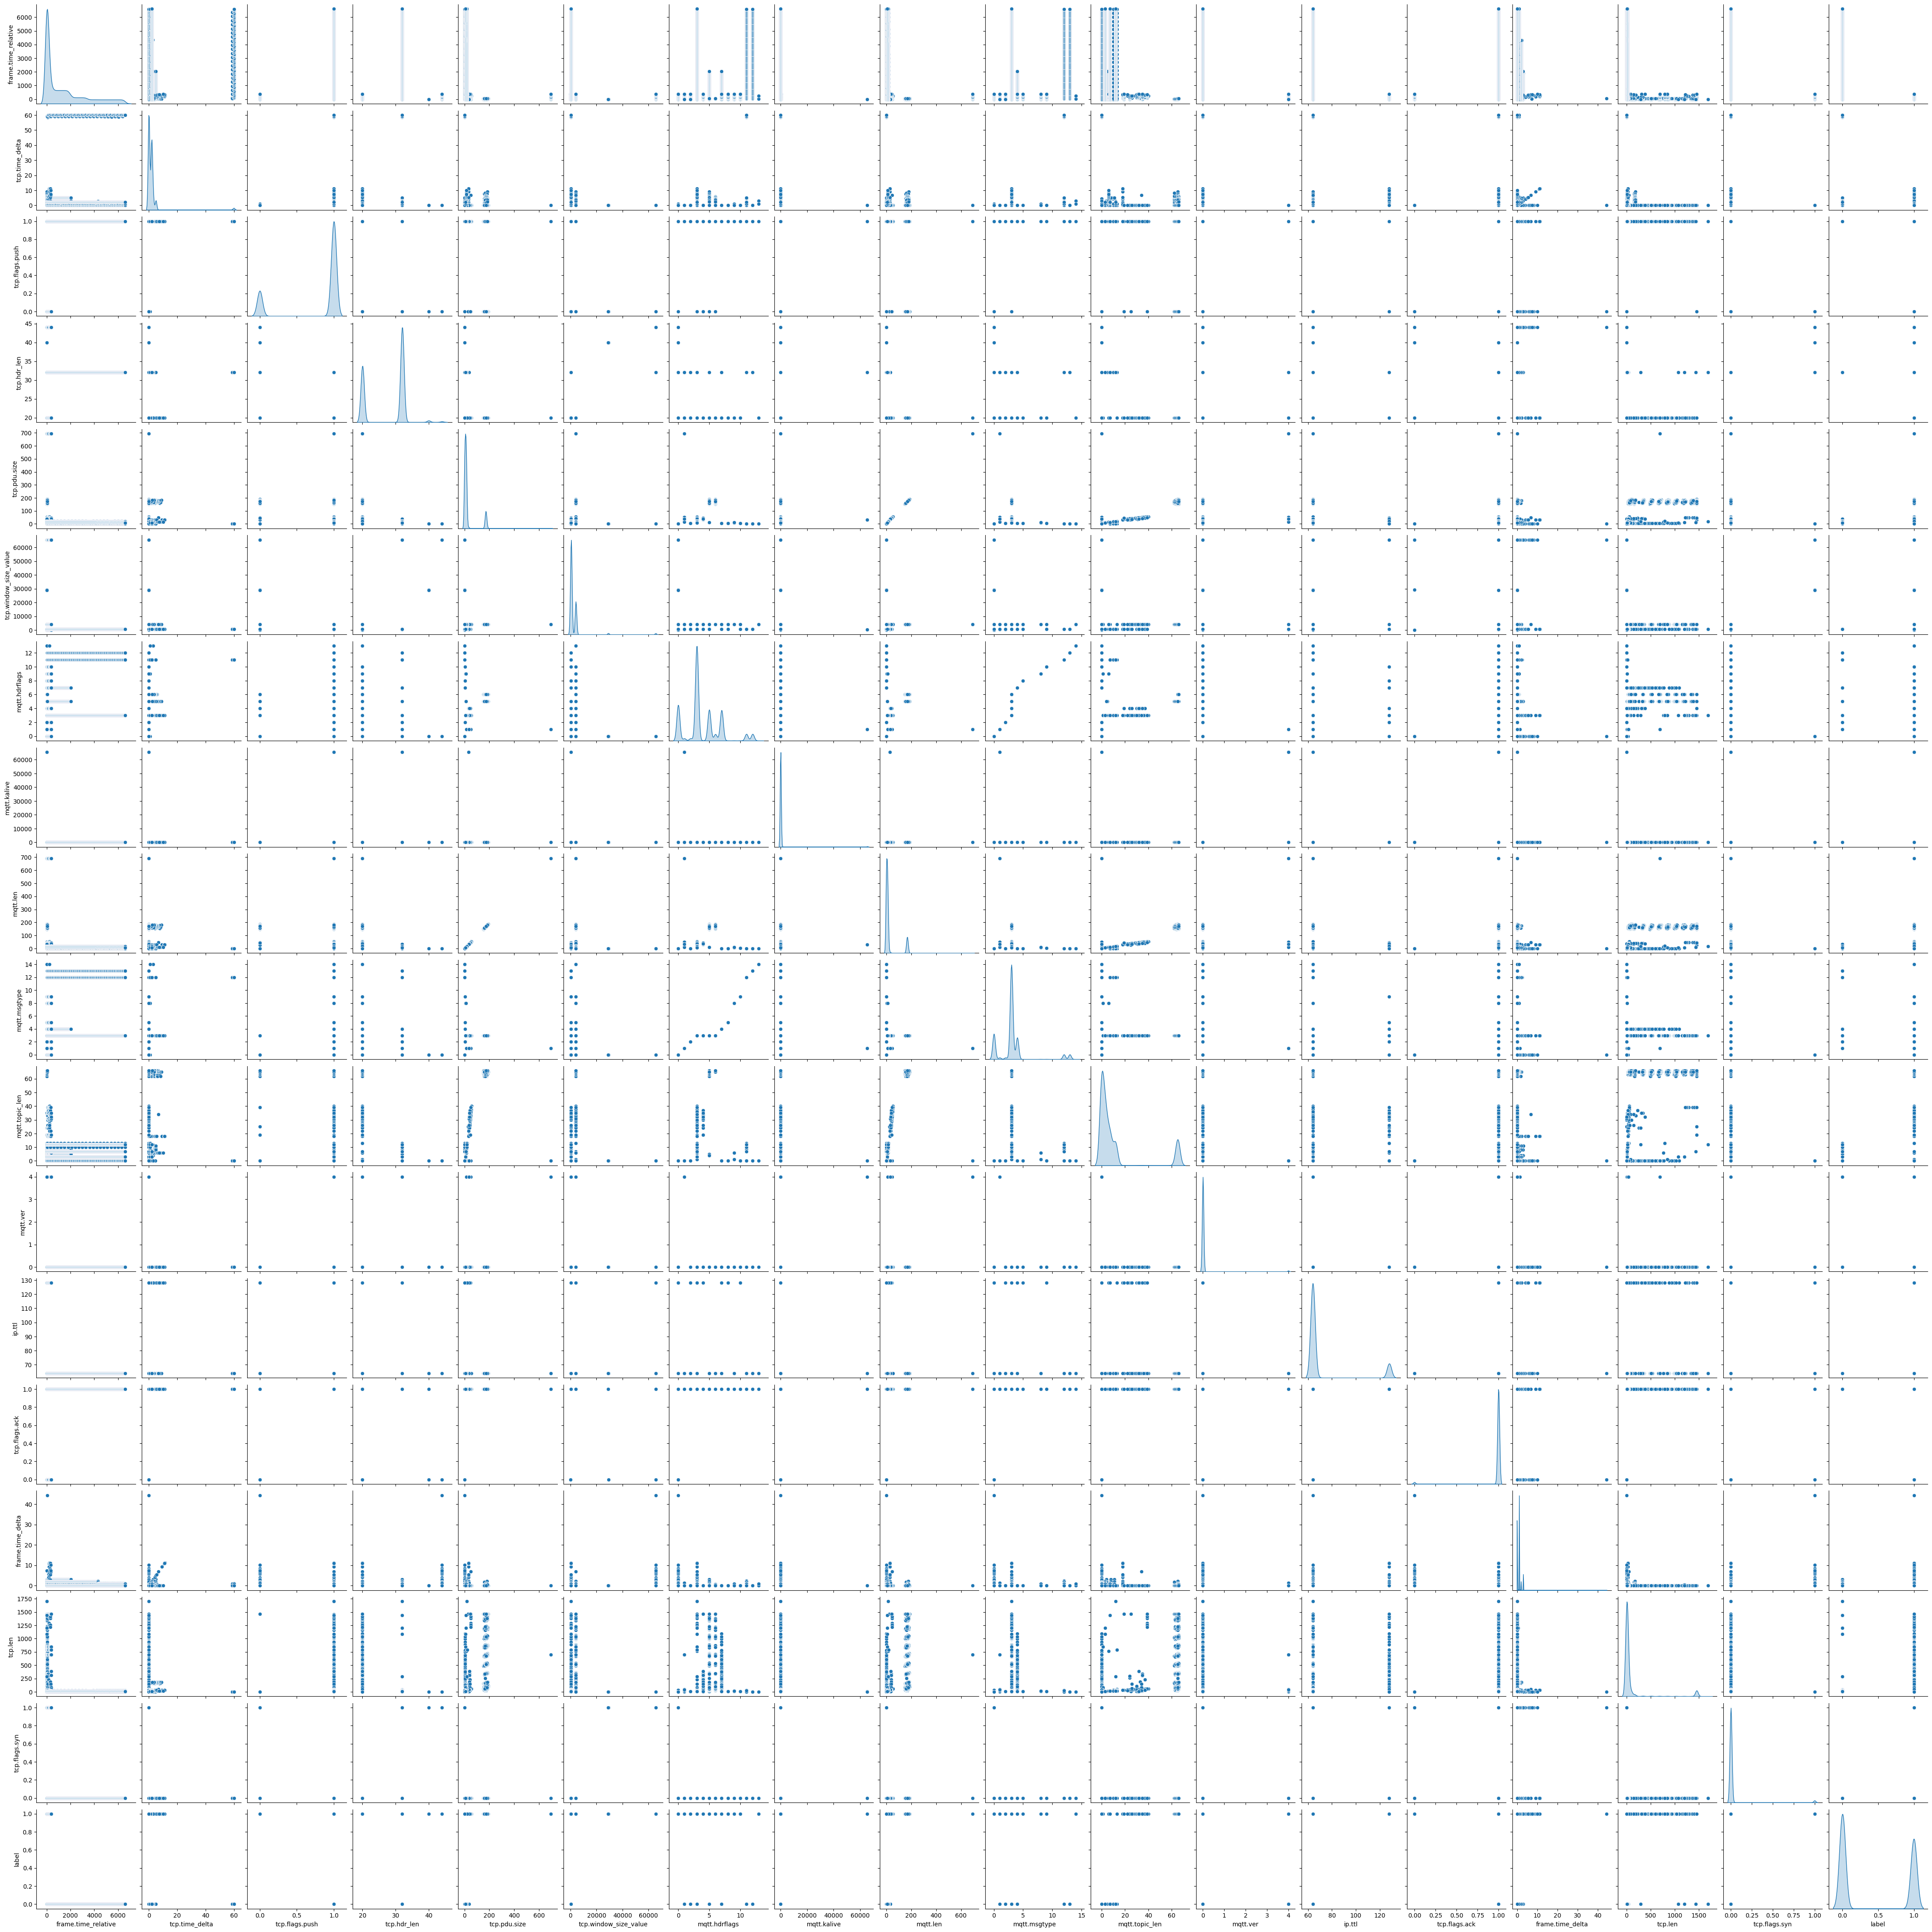

In [ ]:
# plt.figure(figsize=(12,10))
# sns.pairplot(
#     df,
#     diag_kind="kde",
#     palette = ["blue","darkorange"]
# )
# plt.show()

# Divisão dos dados em Variáveis Dependentes e Independentes

In [48]:
#Preparando variáveis dependentes
y = df['label']
y.shape

(188692,)

In [49]:
#Preparando variáveis independentes
X = df.drop('label', axis = 1)
X.shape

(188692, 15)

#Etapa de Normalização e Padronização

In [50]:
scale = StandardScaler()

In [51]:
scale.fit(X)
X_scaled = scale.transform(X)

In [52]:
X_scale_df = pd.DataFrame(X_scaled, columns=X.columns)
X_scale_df

,frame.time_relative,tcp.time_delta,tcp.flags.push,tcp.hdr_len,tcp.pdu.size,tcp.window_size_value,mqtt.hdrflags,mqtt.kalive,mqtt.len,mqtt.msgtype,mqtt.topic_len,mqtt.ver,ip.ttl,tcp.flags.ack,tcp.flags.syn
0,-0.760675,-0.288521,0.516541,0.707485,0.129548,-0.258703,-1.024952,-0.061130,0.127161,-0.819481,-0.550151,9.728160,-0.388221,0.138134,-0.144932
1,-0.760675,-0.288513,0.516541,0.707485,-0.455904,-0.258703,-0.677056,-0.073641,-0.463546,-0.448390,-0.550151,-0.102794,-0.388221,0.138134,-0.144932
2,-0.760675,-0.288521,0.516541,0.707485,0.129548,-0.258703,-1.024952,-0.061130,0.127161,-0.819481,-0.550151,9.728160,-0.388221,0.138134,-0.144932
3,-0.760675,-0.288518,0.516541,0.707485,-0.455904,-0.258703,-0.677056,-0.073641,-0.463546,-0.448390,-0.550151,-0.102794,-0.388221,0.138134,-0.144932
4,-0.760675,-0.288521,0.516541,0.707485,0.129548,-0.258703,-1.024952,-0.061130,0.127161,-0.819481,-0.550151,9.728160,-0.388221,0.138134,-0.144932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188687,2.898636,0.018342,0.516541,0.707485,-0.349458,-0.258703,-0.329161,-0.073641,-0.356145,-0.077299,-0.408158,-0.102794,-0.388221,0.138134,-0.144932
188688,2.898637,0.018338,0.516541,0.707485,-0.367199,-0.258703,-0.329161,-0.073641,-0.374045,-0.077299,-0.408158,-0.102794,-0.388221,0.138134,-0.144932
188689,2.898637,0.018338,0.516541,0.707485,-0.367199,-0.258703,-0.329161,-0.073641,-0.374045,-0.077299,-0.408158,-0.102794,-0.388221,0.138134,-0.144932
188690,2.898637,0.018319,0.516541,0.707485,-0.367199,-0.258703,-0.329161,-0.073641,-0.374045,-0.077299,-0.408158,-0.102794,-0.388221,0.138134,-0.144932


In [ ]:
# # Supondo que rf_model seja o seu modelo Random Forest já treinado
# importances = list(rf_model.feature_importances_)

# # Criar lista de tuplas com a variável e sua importância
# feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X_scale_df, importances)]

# # Ordenar as importâncias em ordem decrescente
# feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

# # Exibir as features e suas importâncias
# print("Features ordenadas por importância:")
# for feature, importance in feature_importances:
#     print(f"Variável: {feature:20} Importância: {importance}")

Features ordenadas por importância:
Variável: frame.time_relative  Importância: 0.43
Variável: tcp.ack              Importância: 0.16
Variável: frame.time_delta     Importância: 0.14
Variável: tcp.time_delta       Importância: 0.12
Variável: tcp.connection.fin   Importância: 0.12
Variável: tcp.connection.rst   Importância: 0.03
Variável: frame.len            Importância: 0.0
Variável: tcp.len              Importância: 0.0
Variável: tcp.connection.sack  Importância: 0.0
Variável: tcp.connection.syn   Importância: 0.0


#Divisão dos dados em Treinamento, Teste e Validação

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_scale_df,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=100)

In [54]:
print('Tamanho de cada uma das amostras:')
print(f'X_train: {X_train.shape}')
print(f'X_test:  {X_test.shape}')
print(f'y_train:  {y_train.shape}')
print(f'y_test: {y_test.shape}')

Tamanho de cada uma das amostras:
X_train: (126423, 15)
X_test:  (62269, 15)
y_train:  (126423,)
y_test: (62269,)


#Parte 1

#Início da Aplicação de Oversampling

In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [58]:
print('Tamanho de cada uma das amostras:')
print(f'X_resampled: {X_resampled.shape}')
print(f'y_resampled:  {y_resampled.shape}')


Tamanho de cada uma das amostras:
X_resampled: (145374, 15)
y_resampled:  (145374,)


#Aplicação de Feature Selection com Regressão Logística (Artigo)

In [ ]:
embeded_LR_selector = SelectFromModel(LogisticRegression(penalty="l1", solver='liblinear'),
                                      threshold='0.9*median',
                                      max_features = 15)

In [ ]:
embeded_LR_selector = SelectFromModel(LogisticRegression(penalty="l1", solver='liblinear'), threshold='0.9*median',
                                      max_features = 15)

In [ ]:
embeded_LR_selector.fit(X_train, y_train)

SelectFromModel(estimator=LogisticRegression(penalty='l1', solver='liblinear'),
                max_features=15, threshold='0.9*median')

In [ ]:
embeded_LR_support = embeded_LR_selector.get_support()

In [ ]:
print('embeded_LR_support', embeded_LR_support)

embeded_LR_support [ True  True False  True False False  True False False  True  True False
 False  True  True]


In [ ]:
embeded_LR_feature = X_train.loc[:,embeded_LR_support].columns.tolist()
print(len(embeded_LR_feature), 'selected features')
print('embeded_LR_features: ', embeded_LR_feature)

8 selected features
embeded_LR_features:  ['frame.time_relative', 'tcp.time_delta', 'tcp.hdr_len', 'mqtt.hdrflags', 'mqtt.msgtype', 'mqtt.topic_len', 'tcp.flags.ack', 'tcp.flags.syn']


#Não utilizei o Feature Selection do Algoritmo (Comparação e Benchmarking)

# Aplicação do Algoritmo SelectKBest para comparação de resultados e benchmarking

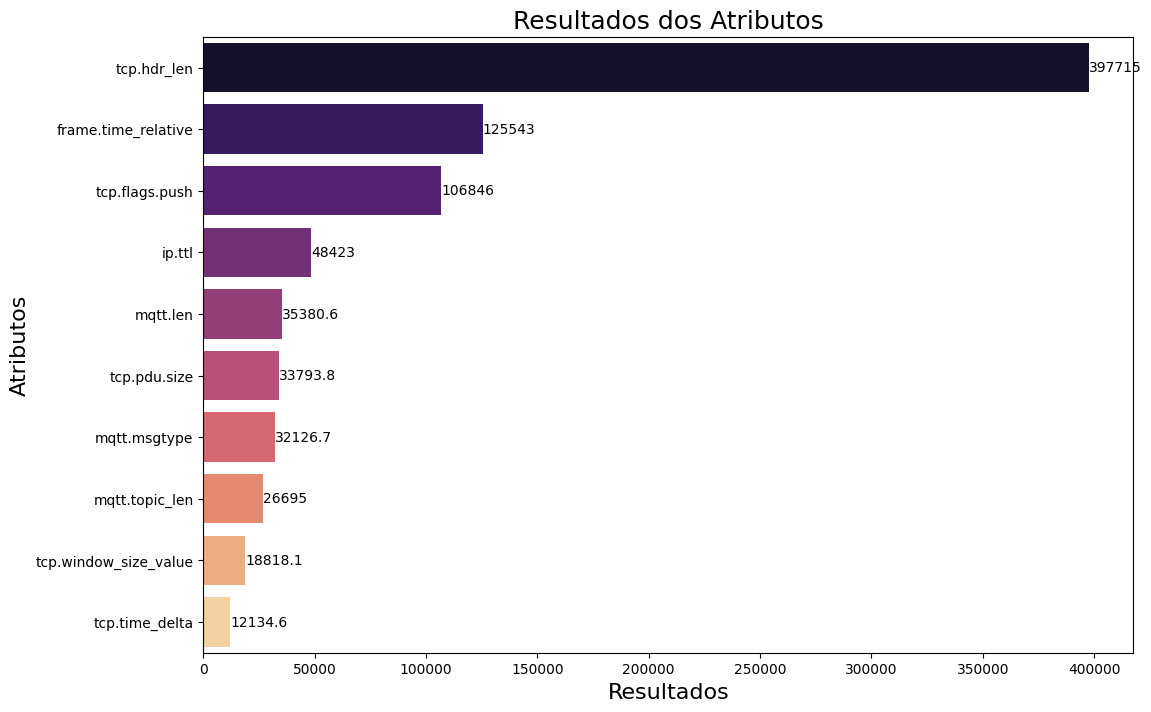

In [ ]:
## Inicializando a classe SelectKBest para encontrar características e aplicando nas variáveis X e y
selector = SelectKBest(f_classif, k=10)
X_selected = selector.fit_transform(X_scale_df, y)

## Criando uma lista de todas as colunas e suas pontuações em variáveis
selected_features = X.columns[selector.get_support()]
feature_scores = selector.scores_[selector.get_support()]

## Criando um Novo Dataframe para armazenar características e suas pontuações
feature_score_df = pd.DataFrame({'Features': selected_features, 'Scores': feature_scores})

## Ordenando o novo dataframe em ordem descendente
feature_score_df = feature_score_df.sort_values(by='Scores', ascending=False)

## Plotando um barplot para melhor insight sobre os atributos e resultados
plt.figure(figsize=(12,8))
ax = sns.barplot(x=feature_score_df['Scores'], y=feature_score_df['Features'], palette='magma')
plt.title('Resultados dos Atributos', fontsize=18)
plt.xlabel('Resultados', fontsize=16)
plt.ylabel('Atributos', fontsize=16)
for lab in ax.containers:
    ax.bar_label(lab)

# Aplicação do Algoritmo de Regressão Logística

In [ ]:
model = LogisticRegression()

# Definição de Parâmetros para o GridSearchCV alinhado ao StratifiedCrossVal

In [ ]:
param_grid_l1 = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l1'],
    'model__solver': ['liblinear']  # solver for L1 penalty
}

param_grid_l2 = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l2'],
    'model__solver': ['lbfgs']  # solver for L2 penalty
}

param_grid_elasticnet = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__penalty': ['elasticnet'],
    'model__l1_ratio': [0.1, 0.5, 0.9],
    'model__solver': ['saga']
}

In [ ]:
# Combinar todas os grids
param_grid = [param_grid_l1, param_grid_l2, param_grid_elasticnet]
param_grid

[{'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
  'model__penalty': ['l1'],
  'model__solver': ['liblinear']},
 {'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
  'model__penalty': ['l2'],
  'model__solver': ['lbfgs']},
 {'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
  'model__penalty': ['elasticnet'],
  'model__l1_ratio': [0.1, 0.5, 0.9],
  'model__solver': ['saga']}]

# StratifiedCrossCV

In [ ]:
# Configurando o StratifiedKFold para validação cruzada estratificada
stratified_kfold = StratifiedKFold(n_splits=5,
                                   shuffle=True,
                                   random_state=42)

# Utilização da Técnica de Oversampling alinhado ao StratifiedKFold com 5 splits

In [ ]:
lst_accu_stratified = []
stratified_kfold = StratifiedKFold(n_splits=5)
smote = SMOTE(random_state=42)

# Stratified k-fold cross-validation com SMOTE
for train_index, test_index in stratified_kfold.split(X_scale_df, y):
    x_train_fold, x_test_fold = X_scale_df.iloc[train_index], X_scale_df.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Aplica SMOTE no conjunto de treinamento
    X_resampled, y_resampled = smote.fit_resample(x_train_fold, y_train_fold)

    # Treina o modelo com os dados aumentados
    model.fit(X_resampled, y_resampled)

    # Calcula a acurácia no conjunto de teste do fold
    accuracy = model.score(x_test_fold, y_test_fold)
    lst_accu_stratified.append(accuracy)

# Lista de acurácias para cada fold
print("Acurácia de cada fold:", lst_accu_stratified)

Acurácia de cada fold: [0.783513076658099, 0.999576035401044, 0.9982510996873178, 1.0, 0.995733743176639]


In [ ]:
# from imblearn.pipeline import Pipeline

In [ ]:
# Define o pipeline com SMOTE e o modelo
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('model', LogisticRegression(max_iter=100))
])

# GridSearchCV

In [ ]:
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=stratified_kfold,  # Stratified cross-validation
    scoring='accuracy',  # Evaluation metric
    n_jobs=-1,  # Use all available cores
    verbose=1  # Verbose output
)

In [ ]:
# Ajustando o GridSearchCV aos dados de treinamento
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'model__penalty': ['l1'],
                          'model__solver': ['liblinear']},
                         {'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'model__penalty': ['l2'],
                          'model__solver': ['lbfgs']},
                         {'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'model__l1_ratio': [0.1, 0.5, 0.9],
                          'model__penalty': ['elasticnet'],
                          'model__solver': ['saga']}],
             scoring='accuracy', verbose=1)

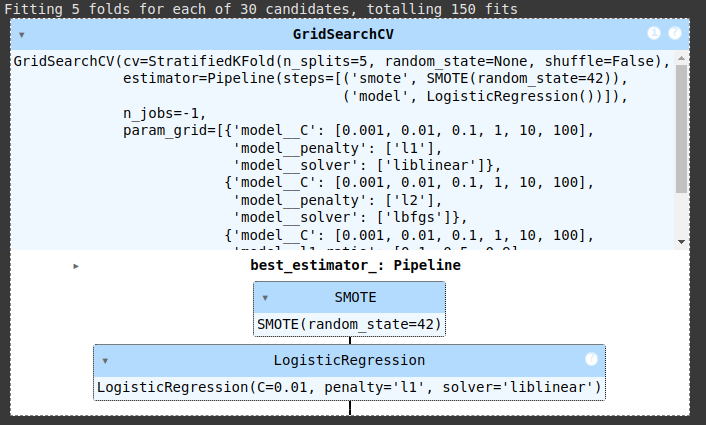

# Melhores parâmetros encontrados com GridSearchCV

In [ ]:
print("Melhores parâmetros encontrados:")
print(grid_search.best_params_)

Melhores parâmetros encontrados:
{'model__C': 0.01, 'model__penalty': 'l1', 'model__solver': 'liblinear'}


Melhores parâmetros encontrados:
{'model__C': 0.01, 'model__penalty': 'l1', 'model__solver': 'liblinear'}

In [ ]:
# Melhor modelo ajustado
best_model = grid_search.best_estimator_
best_model

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('model',
                 LogisticRegression(C=0.01, penalty='l1', solver='liblinear'))])

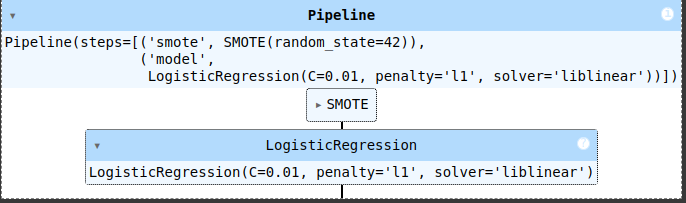

In [ ]:
# Para verificar a acurácia de treino e teste de cada fold
train_acc = []
val_acc = []


In [ ]:
# Fazendo previsões com o melhor modelo
y_pred = best_model.predict(X_test)
y_pred

array([0, 0, 1, ..., 1, 0, 1])

In [ ]:
# Avaliando a acurácia
acuracia = accuracy_score(y_test, y_pred)
print(f'Acurácia do modelo com melhores parâmetros: {acuracia*100:.2f}%')

Acurácia do modelo com melhores parâmetros: 99.93%


# Matriz de Confusão para Novos Dados (Matriz anterior ao Oversampling)

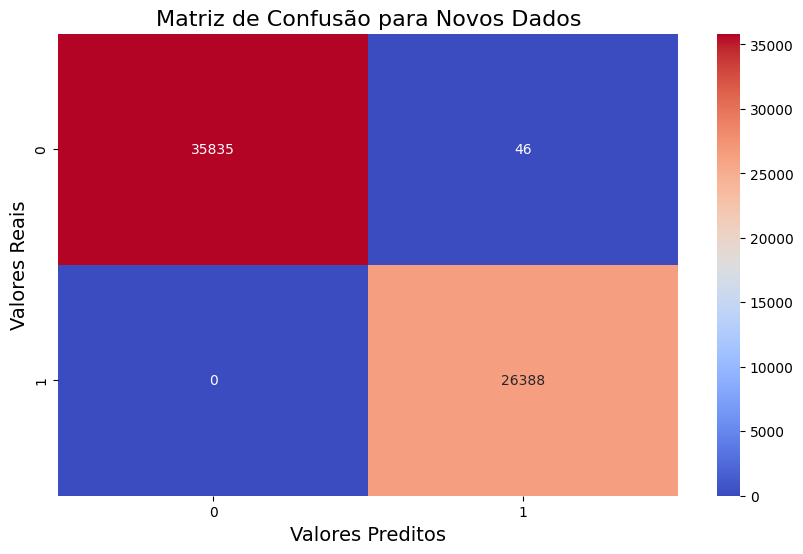

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,6))
plt.title('Matriz de Confusão para Novos Dados', fontsize=16)
sns.heatmap(cm, annot=True, fmt='g', cmap='coolwarm')
plt.xlabel('Valores Preditos', fontsize=14)
plt.ylabel('Valores Reais', fontsize=14)
plt.show()

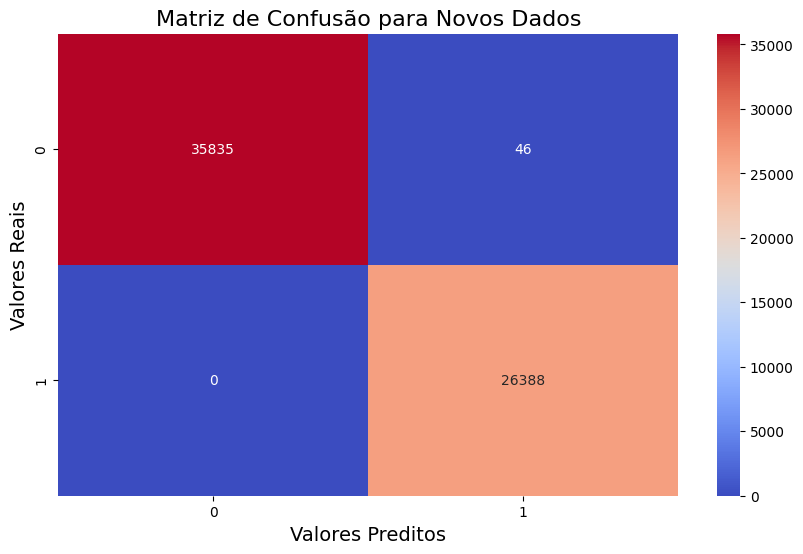

In [ ]:
acuracia = accuracy_score(y_test, y_pred)
precisao = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Metricas:")
print(f'Acuracia: {acuracia*100:.2f}%')
print(f'Precisao: {precisao*100:.2f}%')
print(f'Recall: {recall*100:.2f}%')
print(f'f1-score: {f1*100:.2f}%')

Metricas:
Acuracia: 99.93%
Precisao: 99.83%
Recall: 100.00%
f1-score: 99.91%


In [ ]:
best_model = LogisticRegression(max_iter=10000)
best_model.fit(X_train, y_train)
y_probs = best_model.predict_proba(X_test)[:, 1]

#Calculo da curva ROC e AUC

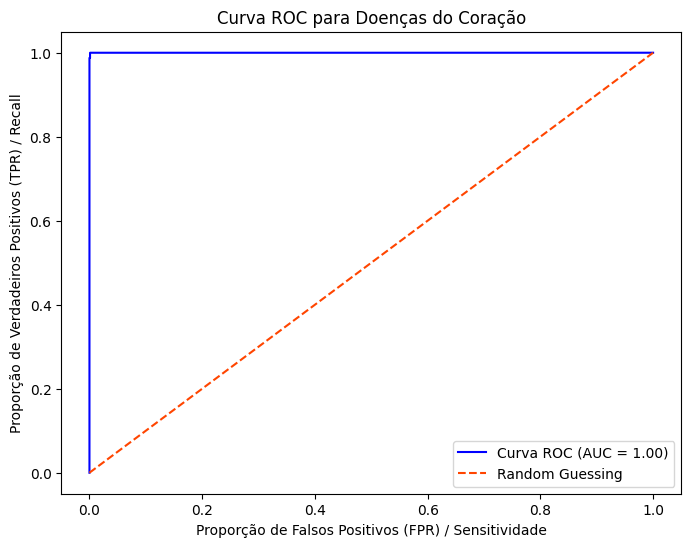

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

# Plotar a ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing', color='orangered')
plt.xlabel('Proporção de Falsos Positivos (FPR) / Sensitividade')
plt.ylabel('Proporção de Verdadeiros Positivos (TPR) / Recall')
plt.title('Curva ROC para Doenças do Coração')
plt.legend()
plt.show()

#Treinamento e Validação (Detecção de Overfitting, Underfitting e Estabilidade )

In [ ]:
# Para verificar a acurácia de treino e teste de cada fold
train_acc = []
val_acc = []

for train_index, test_index in stratified_kfold.split(X_scale_df, y):
    # Dividir os dados em treino e validação para cada fold
    x_train_fold, x_test_fold = X_scale_df.iloc[train_index], X_scale_df.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Treinar o melhor modelo em cada fold de treino
    best_model.fit(x_train_fold, y_train_fold)

    # Calcular e armazenar a acurácia de treino e validação
    train_accuracy = accuracy_score(y_train_fold, best_model.predict(x_train_fold))
    val_accuracy = accuracy_score(y_test_fold, best_model.predict(x_test_fold))
    train_acc.append(train_accuracy)
    val_acc.append(val_accuracy)

# Exibir acurácias de cada fold
print("Acurácia de Treinamento por Fold:", train_acc)
print("Acurácia de Validação por Fold:", val_acc)

# Acurácias médias de treinamento e validação
print("Média de Acurácia de Treinamento:", sum(train_acc) / len(train_acc))
print("Média de Acurácia de Validação:", sum(val_acc) / len(val_acc))

Acurácia de Treinamento por Fold: [1.0, 0.9992779209422801, 0.9996091524570399, 0.9991719331716947, 0.9991851822409475]
Acurácia de Validação por Fold: [0.783513076658099, 0.999576035401044, 0.9982510996873178, 1.0, 0.995733743176639]
Média de Acurácia de Treinamento: 0.9994488377623924
Média de Acurácia de Validação: 0.95541479098462


# Resultados Estáveis Sem Overfitting (Imagem com Overfitting sem Oversampling)

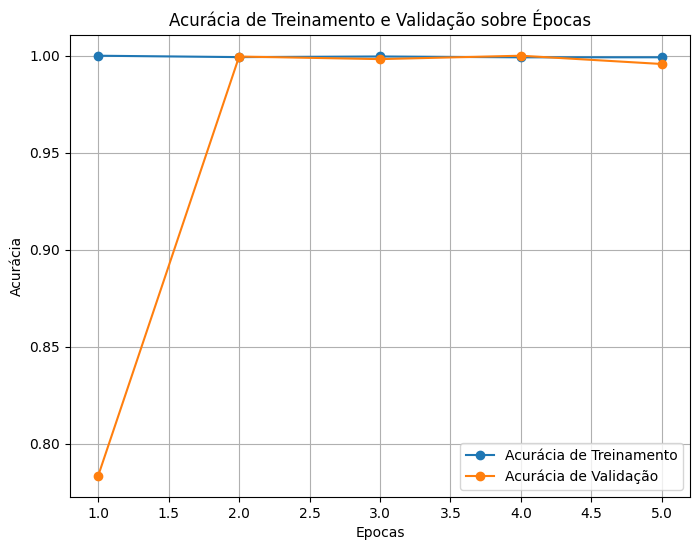

In [ ]:
epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, label='Acurácia de Treinamento', marker='o')
plt.plot(epochs, val_acc, label='Acurácia de Validação', marker='o')
plt.xlabel('Epocas')
plt.ylabel('Acurácia')
plt.title('Acurácia de Treinamento e Validação sobre Épocas')
plt.legend()
plt.grid()
plt.show()



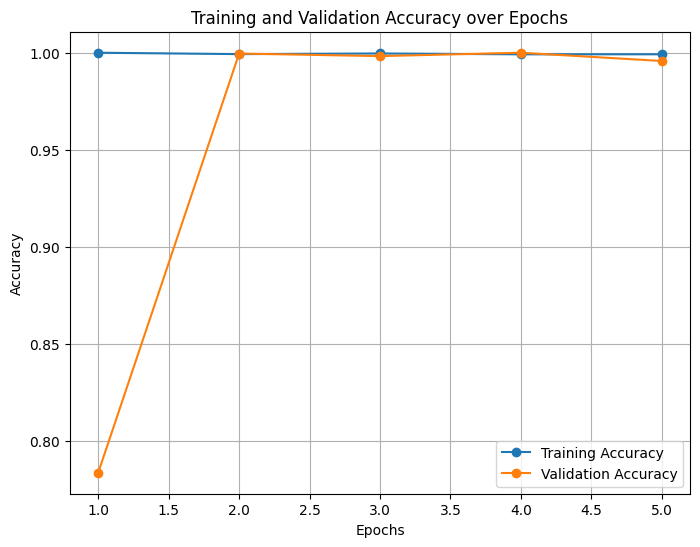

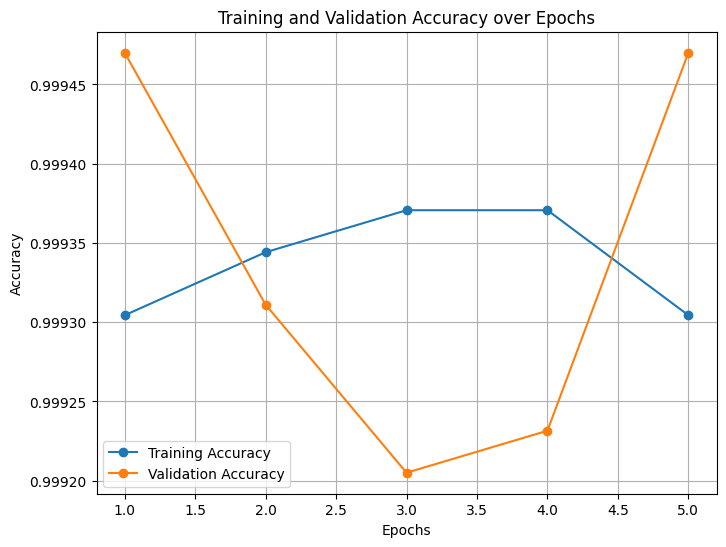

# Parte 2

# Aplicação do Random Forest
- https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf

In [59]:
rf_model = RandomForestClassifier(random_state=42)

- https://www.analyticsvidhya.com/blog/2020/03/beginners-guide-random-forest-hyperparameter-tuning/
- n_estimators = number of trees in the foreset (By default: n_estimators=100). n_estimator is the hyperparameter that defines the number of trees to be used in the model.
- max_features = max number of features considered for splitting a node. Max_features limits a count to select the maximum features in each tree.(By default: max_features="sqrt" [available: ["sqrt", "log2", None}])
- max_depth = max number of levels in each decision tree. max_depth determines the maximum number of splits each tree can take. If the max_depth is too low, the model will be trained less and have a high bias, leading the model to underfit. In the same way, if the max_depth is high, the model learns too much and leads to high variance, leading the model to overfit. (By default: max_depth=None)


- min_samples_split = a parameter that tells the decision tree in a random forest the minimum required number of observations in any given node in order to split it.The default value of the minimum_sample_split is assigned to 2
- min_samples_leaf = min number of data points allowed in a leaf node
- bootstrap = method for sampling data points (with or without replacement)

A. Hyperparameters of a Random Forest include:
1. Number of Trees: The quantity of decision trees in the forest.
2. Tree Depth: Maximum depth of each decision tree.
3. Number of Features: The count of features considered at each split.
4. Criterion: Measure to evaluate quality of splits (e.g., Gini impurity, entropy).
5. Minimum Samples per Leaf: Minimum samples required in a leaf node.
6. Minimum Samples per Split: Minimum samples required to split a node.
7. Bootstrap Sampling: Whether to use bootstrap sampling while building trees.

In [61]:
pprint(rf_model.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


# Definição dos Parâmetros para o Modelo

In [62]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 400, num = 3)]
max_features = ['sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(5, 15, num = 3)]
min_samples_split = [2, 3]
min_samples_leaf = [1, 2]
bootstrap = [True]

# Random Grid

In [79]:
random_grid = {
    'model__n_estimators': n_estimators,
    'model__max_features': max_features,
    'model__max_depth': max_depth,
    'model__min_samples_split': min_samples_split,
    'model__min_samples_leaf': min_samples_leaf,
    'model__bootstrap': bootstrap
}

In [80]:
pprint(random_grid )

{'model__bootstrap': [True],
 'model__max_depth': [5, 10, 15],
 'model__max_features': ['sqrt', 'log2'],
 'model__min_samples_leaf': [1, 2],
 'model__min_samples_split': [2, 3],
 'model__n_estimators': [100, 250, 400]}


# Treinamento com Random Search utilizando o StratifiedKFold
- Os argumentos mais importantes no RandomizedSearchCV são n_iter, que controla o número de diferentes combinações a serem testadas, e cv stratified_kfold com , que é o número de folds a serem usados para validação cruzada. Mais iterações cobrirão um espaço de busca mais amplo e mais dobras de validação cruzada reduzem as chances de overfitting, mas aumentar cada um deles aumentará o tempo de execução.

In [65]:
# Configurando o StratifiedKFold para validação cruzada estratificada
stratified_kfold = StratifiedKFold(n_splits=3,
                                   shuffle=True,
                                   random_state=42)

In [67]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [68]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)


In [69]:
lst_accu_stratified = []
stratified_kfold = StratifiedKFold(n_splits=5)
smote = SMOTE(random_state=42)

In [70]:
print('Tamanho de cada uma das amostras:')
print(f'X_resampled: {X_resampled.shape}')
print(f'y_resampled:  {y_resampled.shape}')

Tamanho de cada uma das amostras:
X_resampled: (145374, 15)
y_resampled:  (145374,)


In [73]:
# Stratified k-fold cross-validation com SMOTE
for train_index, test_index in stratified_kfold.split(X_scale_df, y):
    x_train_fold, x_test_fold = X_scale_df.iloc[train_index], X_scale_df.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Aplica SMOTE no conjunto de treinamento
    X_resampled, y_resampled = smote.fit_resample(x_train_fold, y_train_fold)

    # Treina o modelo com os dados aumentados
    rf_model.fit(X_resampled, y_resampled)

    # Calcula a acurácia no conjunto de teste do fold
    accuracy = rf_model.score(x_test_fold, y_test_fold)
    lst_accu_stratified.append(accuracy)

# Lista de acurácias para cada fold
print("Acurácia de cada fold:", lst_accu_stratified)


Acurácia de cada fold: [0.9331990778769973, 1.0, 1.0, 1.0, 0.9997880120833113]


In [76]:
# Define o pipeline com SMOTE e o modelo
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('model', RandomForestClassifier(random_state=42))
])

In [81]:
rf_random = RandomizedSearchCV(estimator = pipeline,
                               param_distributions = random_grid,
                               n_iter = 30,
                               cv = stratified_kfold,
                               verbose=2,
                               random_state=42,
                               n_jobs = -1)

# Tempo: 50m23s

In [82]:
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                             ('model',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'model__bootstrap': [True],
                                        'model__max_depth': [5, 10, 15],
                                        'model__max_features': ['sqrt', 'log2'],
                                        'model__min_samples_leaf': [1, 2],
                                        'model__min_samples_split': [2, 3],
                                        'model__n_estimators': [100, 250, 400]},
                   random_state=42, verbose=2)

In [84]:
print("Melhores parâmetros encontrados:")
pprint(rf_random.best_params_)


Melhores parâmetros encontrados:
{'model__bootstrap': True,
 'model__max_depth': 15,
 'model__max_features': 'log2',
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 400}


Melhores parâmetros encontrados:
{'model__bootstrap': True,
 'model__max_depth': 15,
 'model__max_features': 'log2',
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 400}

In [85]:
# Melhor modelo ajustado
best_model = rf_random.best_estimator_
best_model

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('model',
                 RandomForestClassifier(max_depth=15, max_features='log2',
                                        n_estimators=400, random_state=42))])

In [87]:
# Fazendo previsões com o melhor modelo
y_pred = best_model.predict(X_test)
y_pred

array([0, 0, 1, ..., 1, 0, 1])

In [88]:
# Avaliando a acurácia
acuracia = accuracy_score(y_test, y_pred)
print(f'Acurácia do modelo com melhores parâmetros: {acuracia*100:.2f}%')

Acurácia do modelo com melhores parâmetros: 100.00%


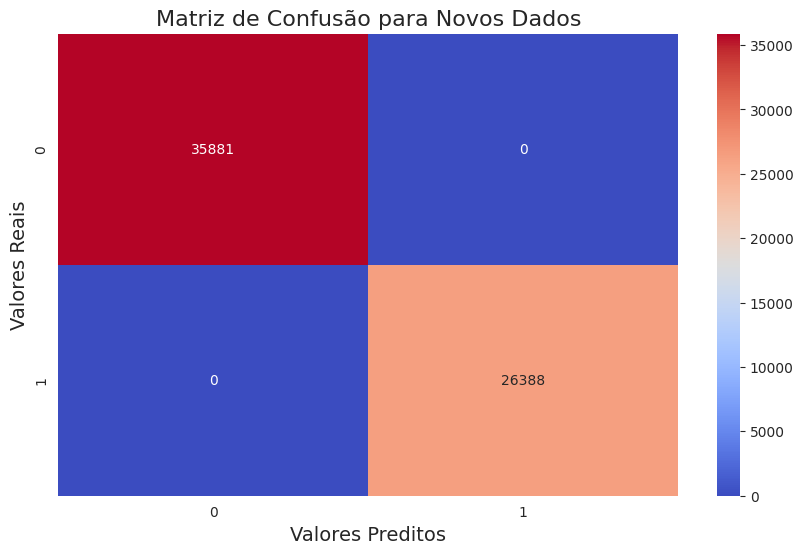

In [89]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,6))
plt.title('Matriz de Confusão para Novos Dados', fontsize=16)
sns.heatmap(cm, annot=True, fmt='g', cmap='coolwarm')
plt.xlabel('Valores Preditos', fontsize=14)
plt.ylabel('Valores Reais', fontsize=14)
plt.show()

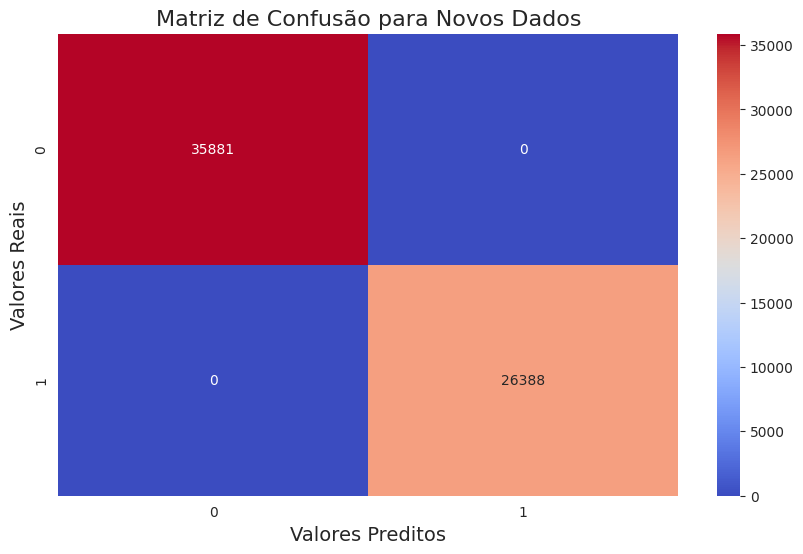

In [90]:
acuracia = accuracy_score(y_test, y_pred)
precisao = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Metricas:")
print(f'Acuracia: {acuracia*100:.2f}%')
print(f'Precisao: {precisao*100:.2f}%')
print(f'Recall: {recall*100:.2f}%')
print(f'f1-score: {f1*100:.2f}%')

Metricas:
Acuracia: 100.00%
Precisao: 100.00%
Recall: 100.00%
f1-score: 100.00%


In [91]:
y_probs = best_model.predict_proba(X_test)[:, 1]

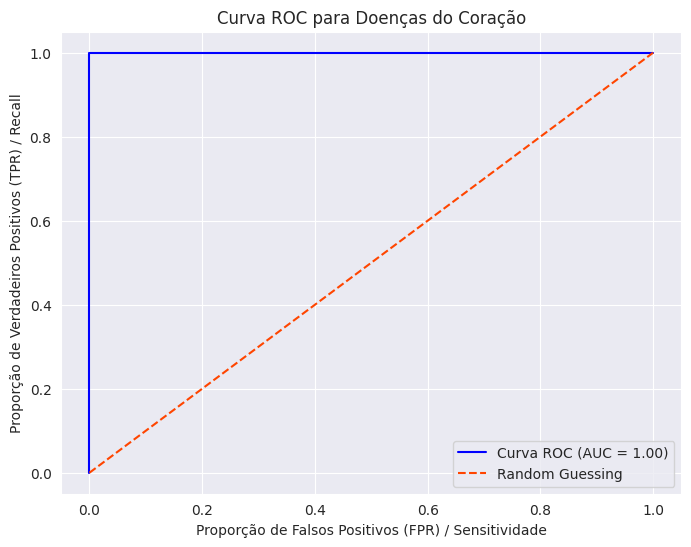

In [92]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

# Plotar a ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing', color='orangered')
plt.xlabel('Proporção de Falsos Positivos (FPR) / Sensitividade')
plt.ylabel('Proporção de Verdadeiros Positivos (TPR) / Recall')
plt.title('Curva ROC para Doenças do Coração')
plt.legend()
plt.show()

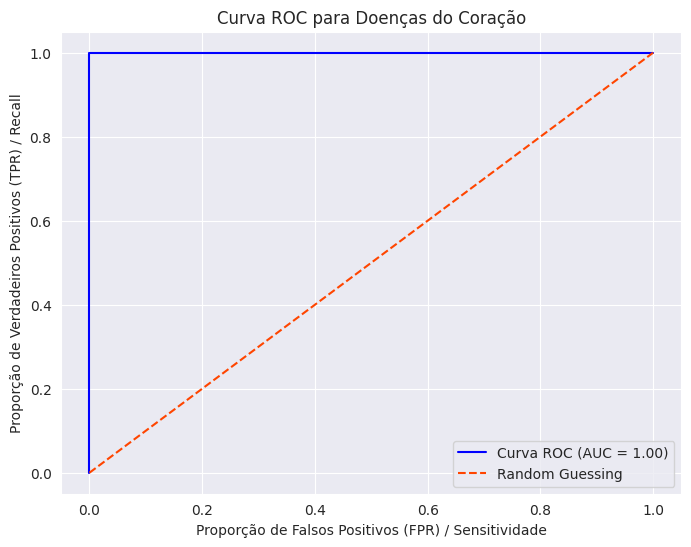

In [93]:
# Para verificar a acurácia de treino e teste de cada fold
train_acc = []
val_acc = []

for train_index, test_index in stratified_kfold.split(X_scale_df, y):
    # Dividir os dados em treino e validação para cada fold
    x_train_fold, x_test_fold = X_scale_df.iloc[train_index], X_scale_df.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Treinar o melhor modelo em cada fold de treino
    best_model.fit(x_train_fold, y_train_fold)

    # Calcular e armazenar a acurácia de treino e validação
    train_accuracy = accuracy_score(y_train_fold, best_model.predict(x_train_fold))
    val_accuracy = accuracy_score(y_test_fold, best_model.predict(x_test_fold))
    train_acc.append(train_accuracy)
    val_acc.append(val_accuracy)

# Exibir acurácias de cada fold
print("Acurácia de Treinamento por Fold:", train_acc)
print("Acurácia de Validação por Fold:", val_acc)

Acurácia de Treinamento por Fold: [1.0, 1.0, 1.0, 1.0, 1.0]
Acurácia de Validação por Fold: [0.926044675269615, 1.0, 1.0, 1.0, 0.9990460543749007]


Acurácia de Treinamento por Fold: [1.0, 1.0, 1.0, 1.0, 1.0]
Acurácia de Validação por Fold: [0.926044675269615, 1.0, 1.0, 1.0, 0.9990460543749007]

In [94]:
# Acurácias médias de treinamento e validação
print("Média de Acurácia de Treinamento:", sum(train_acc) / len(train_acc))
print("Média de Acurácia de Validação:", sum(val_acc) / len(val_acc))

Média de Acurácia de Treinamento: 1.0
Média de Acurácia de Validação: 0.9850181459289031


Média de Acurácia de Treinamento: 1.0
Média de Acurácia de Validação: 0.9850181459289031

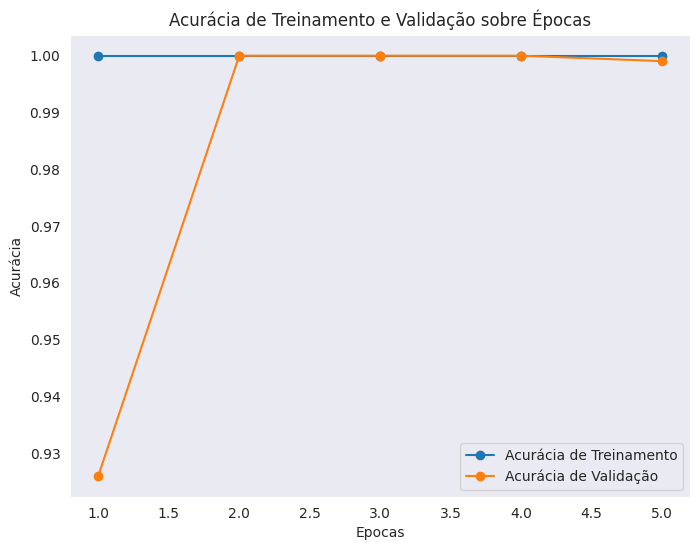

In [95]:
epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, label='Acurácia de Treinamento', marker='o')
plt.plot(epochs, val_acc, label='Acurácia de Validação', marker='o')
plt.xlabel('Epocas')
plt.ylabel('Acurácia')
plt.title('Acurácia de Treinamento e Validação sobre Épocas')
plt.legend()
plt.grid()
plt.show()

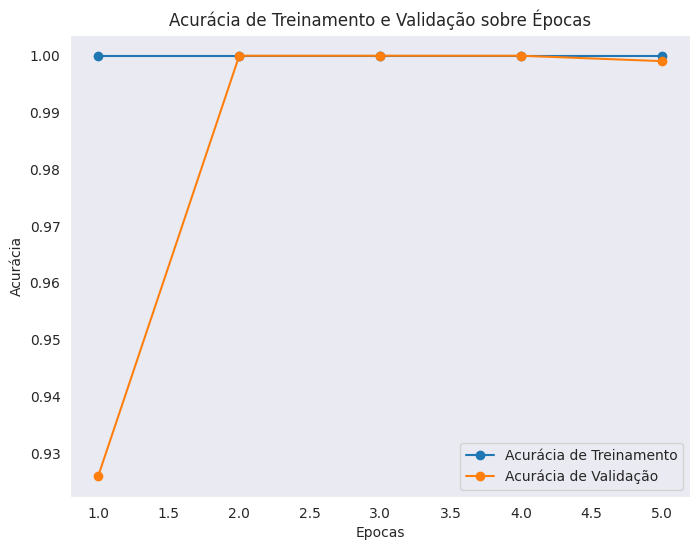